# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [29]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 2

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [19]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================

In [30]:
N = X_full.shape[0]

perm = torch.randperm(N)
train_idx = perm[:2100]
val_idx = perm[2100:]

X_train = X_full[train_idx]
y_train = y_full[train_idx]

X_val = X_full[val_idx]
y_val = y_full[val_idx]


In [31]:
def relu(x):
    return torch.clamp(x, min=0)

def sigmoid(x):
    return 1.0 / (1.0 + torch.exp(-x))


In [32]:
def binary_cross_entropy(y_hat, y):
    eps = 1e-8
    y_hat = torch.clamp(y_hat, eps, 1 - eps)
    return -(y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat)).mean()


In [33]:
def init_param(in_dim, out_dim):
    W = torch.randn(in_dim, out_dim)
    W *= 0.1
    W.requires_grad_()

    b = torch.zeros(1, out_dim)
    b.requires_grad_()
    return W, b


In [34]:
W1, b1 = init_param(2, 16)
W2, b2 = init_param(16, 16)
W3, b3 = init_param(16, 16)
W4, b4 = init_param(16, 1)

params = [W1, b1, W2, b2, W3, b3, W4, b4]


In [35]:
def forward(X):
    z1 = torch.matmul(X, W1) + b1
    a1 = relu(z1)

    z2 = torch.matmul(a1, W2) + b2
    a2 = relu(z2)

    z3 = torch.matmul(a2, W3) + b3
    a3 = relu(z3)

    z4 = torch.matmul(a3, W4) + b4
    out = sigmoid(z4)

    return out


In [36]:
def accuracy(y_hat, y):
    preds = (y_hat > 0.5).float()
    return (preds == y).float().mean().item()


In [37]:
lr = 0.01
epochs = 1000

train_loss, val_loss = [], []
train_acc, val_acc = [], []

for epoch in range(epochs):

    y_hat = forward(X_train)
    loss = binary_cross_entropy(y_hat, y_train)

    loss.backward()

    # manual SGD update
    with torch.no_grad():
        for p in params:
            p -= lr * p.grad
            p.grad.zero_()

        # logging
        train_loss.append(loss.item())
        val_loss.append(binary_cross_entropy(forward(X_val), y_val).item())

        train_acc.append(accuracy(forward(X_train), y_train))
        val_acc.append(accuracy(forward(X_val), y_val))

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Train Acc: {train_acc[-1]:.3f} | Val Acc: {val_acc[-1]:.3f}")


Epoch 0 | Train Acc: 0.492 | Val Acc: 0.483
Epoch 100 | Train Acc: 0.610 | Val Acc: 0.601
Epoch 200 | Train Acc: 0.610 | Val Acc: 0.601
Epoch 300 | Train Acc: 0.610 | Val Acc: 0.601
Epoch 400 | Train Acc: 0.610 | Val Acc: 0.601
Epoch 500 | Train Acc: 0.610 | Val Acc: 0.601
Epoch 600 | Train Acc: 0.610 | Val Acc: 0.601
Epoch 700 | Train Acc: 0.610 | Val Acc: 0.601
Epoch 800 | Train Acc: 0.610 | Val Acc: 0.601
Epoch 900 | Train Acc: 0.610 | Val Acc: 0.601


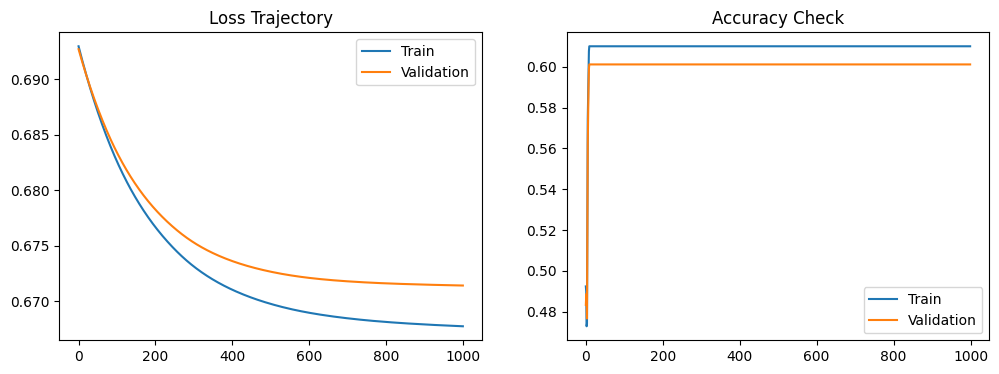

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_loss, label="Train")
plt.plot(val_loss, label="Validation")
plt.title("Loss Trajectory")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc, label="Train")
plt.plot(val_acc, label="Validation")
plt.title("Accuracy Check")
plt.legend()

plt.show()


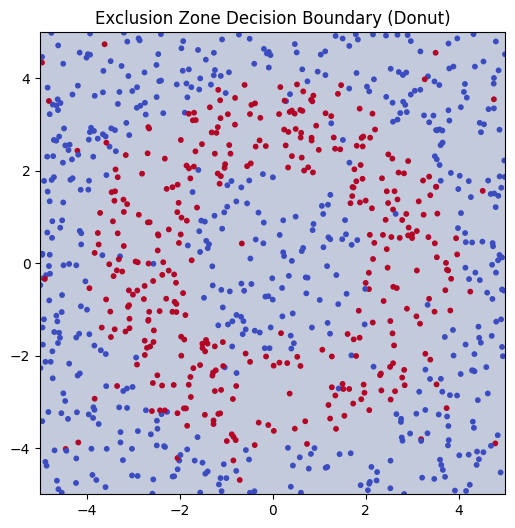

In [39]:
xx, yy = torch.meshgrid(
    torch.linspace(-5, 5, 400),
    torch.linspace(-5, 5, 400),
    indexing="ij"
)

grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)

with torch.no_grad():
    preds = forward(grid).reshape(xx.shape)

plt.figure(figsize=(6,6))
plt.contourf(xx.numpy(), yy.numpy(), preds.numpy() > 0.5, alpha=0.3)
plt.scatter(X_val[:,0], X_val[:,1], c=y_val[:,0], cmap="coolwarm", s=10)
plt.title("Exclusion Zone Decision Boundary (Donut)")
plt.show()
